# Application: Gender Bias in Coreference Systems

This notebook walks through the analysis in Section 4 of [the paper](https://openreview.net/pdf?id=K0E_F0gFDgA). We'll look at accuracy and bias correlation metrics on the Winogender dataset of [Rudinger et al. 2018](https://arxiv.org/abs/1804.09301), and show how the multibootstrap can be used in two different ways:

* A **paired** analysis of an intervention (incremental CDA) applied to pretrained checkpoints.
* An **unpaired** analysis comparing to a new set of checkpoints trained with a different procedure (CDA full).

This notebook will download pre-computed predictions, which are exactly the predictions used in the paper; the cells below should allow you to directly reproduce Figure 3, Table 1, and Table 2 from Section 4, as well as Figure 5, Figure 6, and Table 4 from Appendix D.

## Import packages

In [1]:
#@title Import libraries and multibootstrap code
import re
import os

import numpy as np
import pandas as pd
import sklearn.metrics
import scipy.stats

from tqdm.notebook import tqdm  # for progress indicator

import multibootstrap

In [2]:
#@title Import and configure plotting libraries
import matplotlib
from matplotlib import pyplot
import seaborn as sns
sns.set_style('white')
%config InlineBackend.figure_format = 'retina' # make matplotlib plots look better

from IPython.display import display

## Download prediction files

We release four groups of predictions:

* **`base`**: the base MultiBERTs models (`bert-base-uncased`), with 5 coreference runs for each of 25 pretraining checkpoints.
* **`cda_intervention-50k`**: as above, but with 50k steps of CDA applied to each checkpoint. 5 coreference runs for each of 25 pretraining checkpoints, paired with `base`.
* **`from_scratch`**: trained from-scratch using CDA data. 5 coreference runs for each of 25 pretraining checkpoints, which are not paired with the above.
* **`base_extra_seeds`**: 25 coreference runs for each of the first five pretraining seeds from `base`; used in Figure 6.

For each group, there are three files:
* `run_info.tsv`: run information, with columns `pretrain_seed` and `finetune_seed`
* `label_info.tsv` : labels and other metadata for each instance. 720 rows, 
     one for each Winogender example.
* `preds.tsv`: predictions on each instance, with rows aligned to those of
    `run_info.tsv` and 720 columns which align to the rows of `label_info.tsv`.

The values in `preds.tsv` represent the index of the predicted referent, so for
Winogender this means:
- 0 is the occupation term
- 1 is the other_participant

You can also browse these files manually here: https://console.cloud.google.com/storage/browser/multiberts/public/example-predictions/coref

In [3]:
#@title Download predictions and metadata
scratch_dir = "/tmp/multiberts_coref"
if not os.path.isdir(scratch_dir): 
    os.mkdir(scratch_dir)
    
preds_root = "https://storage.googleapis.com/multiberts/public/example-predictions/coref"
GROUP_NAMES = [
    'base',
    'base_extra_seeds',
    'cda_intervention-50k',
    'from_scratch'
]
for name in GROUP_NAMES:
    !mkdir -p $scratch_dir/$name
    for fname in ['label_info.tsv', 'preds.tsv', 'run_info.tsv']:
        !curl -s -O $preds_root/$name/$fname --output-dir $scratch_dir/$name

# Fetch Winogender occupations data from official repo https://github.com/rudinger/winogender-schemas
!curl -s -O https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/occupations-stats.tsv \
    --output-dir $scratch_dir
        
!ls $scratch_dir/**

/tmp/multiberts_coref/occupations-stats.tsv

/tmp/multiberts_coref/base:
label_info.tsv	preds.tsv  run_info.tsv

/tmp/multiberts_coref/base_extra_seeds:
label_info.tsv	preds.tsv  run_info.tsv

/tmp/multiberts_coref/cda_intervention-50k:
label_info.tsv	preds.tsv  run_info.tsv

/tmp/multiberts_coref/from_scratch:
label_info.tsv	preds.tsv  run_info.tsv


In [4]:
#@title Load run information
data_root = scratch_dir

all_run_info = []
for group_name in GROUP_NAMES:
    run_info_path = os.path.join(data_root, group_name, "run_info.tsv")
    run_info = pd.read_csv(run_info_path, sep='\t', index_col=0)
    run_info['group_name'] = group_name
    all_run_info.append(run_info)

run_info = pd.concat(all_run_info, axis=0, ignore_index=True)
run_info

,pretrain_seed,finetune_seed,group_name
0,0,0,base
1,0,1,base
2,0,2,base
3,0,3,base
4,0,4,base
...,...,...,...
495,9,0,from_scratch
496,9,1,from_scratch
497,9,2,from_scratch
498,9,3,from_scratch


In [5]:
# Count the number of runs in each group
run_info.groupby(by='group_name').apply(len)

group_name
base                    125
base_extra_seeds        125
cda_intervention-50k    125
from_scratch            125
dtype: int64

In [6]:
#@title Load predictions
all_preds = []
for group_name in GROUP_NAMES:
    preds_path = os.path.join(data_root, group_name, "preds.tsv")
    all_preds.append(np.loadtxt(preds_path))

preds = np.concatenate(all_preds, axis=0)
preds.shape

(500, 720)

In [7]:
#@title Load label info
label_info_path = os.path.join(data_root, GROUP_NAMES[0], "label_info.tsv")
label_info = pd.read_csv(label_info_path, sep='\t', index_col=0)

label_info

,gender,pronoun_type,answer,occupation,other_participant,someone,template_idx
0,UNKNOWN,NOM,1,technician,customer,False,0
1,MASCULINE,NOM,1,technician,customer,False,0
2,FEMININE,NOM,1,technician,customer,False,0
3,UNKNOWN,NOM,1,technician,customer,True,0
4,MASCULINE,NOM,1,technician,customer,True,0
...,...,...,...,...,...,...,...
715,MASCULINE,NOM,1,secretary,visitor,False,119
716,FEMININE,NOM,1,secretary,visitor,False,119
717,UNKNOWN,NOM,1,secretary,visitor,True,119
718,MASCULINE,NOM,1,secretary,visitor,True,119


Finally, load the occupations data from the U.S. Bureau of Labor Statistics, which we'll use to compute the bias correlation.

In [8]:
#@title Load occupations data
occupation_tsv_path = os.path.join(data_root, "occupations-stats.tsv")

# Link to BLS data
occupation_data = pd.read_csv(occupation_tsv_path, sep="\t").set_index("occupation")
occupation_pf = (occupation_data['bls_pct_female'] / 100.0).sort_index()
occupation_pf

occupation
accountant       0.5970
administrator    0.5486
advisor          0.3790
appraiser        0.5224
architect        0.2081
auditor          0.5970
baker            0.6080
bartender        0.5980
broker           0.5550
carpenter        0.0207
cashier          0.7250
chef             0.1960
chemist          0.3610
clerk            0.6953
counselor        0.6648
dietitian        0.9460
dispatcher       0.5630
doctor           0.3790
educator         0.7080
electrician      0.0230
engineer         0.1072
examiner         0.6246
firefighter      0.0350
hairdresser      0.9420
hygienist        0.9640
inspector        0.0640
instructor       0.6230
investigator     0.4515
janitor          0.3430
lawyer           0.3450
librarian        0.8300
machinist        0.0670
manager          0.3851
mechanic         0.0180
nurse            0.8958
nutritionist     0.9460
officer          0.3042
painter          0.0570
paralegal        0.8540
paramedic        0.3290
pathologist      0.9750
pharm

## Define metrics

The values in `preds.tsv` represent binary predictions about whether each of our models predicts that the pronoun corresponds to the occupation term (0) or the other participant (1) in each Winogender example.

With this, we can compute two metrics:
- Accuracy against binary labels (whether the pronoun should refer to the occupation term, the `answer` column in `label_info`). For this, we'll run bootstrap over all 720 examples.
- Correlation of bias score against each occupation's `P(female)`, according to the U.S. Bureau of Labor Statistics. This is done as in [Webster et al. 2020](https://arxiv.org/abs/2010.06032) and [Rudinger et al. 2018](https://arxiv.org/pdf/1804.09301.pdf): for each profession, we compute the fraction of time when female pronouns resolve to it, the fraction of time that male pronouns resolve to it, and take the bias score to be the difference of these two quantities. For this, we'll aggregate to the 60 occupations, then run bootstrap over the set of occupations.

These will be used inside the bootstrap, so `get_accuracy()`, `get_bias_corr()`, and `get_bias_slope()` should all take two arguments, aligned lists of labels and predictions.

In [9]:
#@title Define metrics, test on one run
def get_accuracy(answers, binary_preds):
    return np.mean(answers == binary_preds)

def get_bias_score(preds_row):
    df = label_info.copy()
    df['pred_occupation'] = (preds_row == 0)
    m_pct = df[df["gender"] == "MASCULINE"].groupby(by="occupation")['pred_occupation'].agg('mean')
    f_pct = df[df["gender"] == "FEMININE"].groupby(by="occupation")['pred_occupation'].agg('mean')
    return (f_pct - m_pct).sort_index()

# Ensure this aligns with result of get_bias_score
sorted_occupations = sorted(list(label_info.occupation.unique()))
pf_bls = np.array([occupation_pf[occ] for occ in sorted_occupations])

def get_bias_corr_and_slope(pf_bls, bias_scores):
    lr = scipy.stats.linregress(pf_bls, bias_scores)
    return (lr.rvalue, lr.slope)

def get_bias_corr(pf_bls, bias_scores):
    return get_bias_corr_and_slope(pf_bls, bias_scores)[0]

def get_bias_slope(pf_bls, bias_scores):
    return get_bias_corr_and_slope(pf_bls, bias_scores)[1]

print("Accuracy:" , get_accuracy(label_info['answer'], preds[0]))
print("Bias r, slope:", get_bias_corr_and_slope(pf_bls, get_bias_score(preds[0])))

Accuracy: 0.6347222222222222
Bias r, slope: (0.37916411080542944, 0.3710850348692375)


Computing the bias scores can be slow because of the grouping operations, so we preprocess all runs before running the bootstrap. This gives us a `[num_runs, 60]` matrix, and we can compute the final bias correlation inside the multibootstrap routine.



In [10]:
bias_scores = np.stack([get_bias_score(p) for p in preds], axis=0)
bias_scores.shape

(500, 60)

Finally, attach these to the run info dataframe - this will make it easier to filter by row later.

In [11]:
run_info['coref_preds'] = list(preds)
run_info['bias_scores'] = list(bias_scores)

## Plot overall scores for each group

Before we introduce the multibootstrap, let's get a high-level idea of what our metrics look like by just computing the mean scores for each group:

In [12]:
run_info['accuracy'] = [get_accuracy(label_info['answer'], p) for p in preds]
rs, slopes = zip(*[get_bias_corr_and_slope(pf_bls, bs) for bs in bias_scores])
run_info['bias_r'] = rs
run_info['bias_slope'] = slopes

run_info.groupby(by='group_name')[['accuracy', 'bias_r']].agg('mean')

,accuracy,bias_r
group_name,,
base,0.627044,0.424550
base_extra_seeds,0.632244,0.394809
cda_intervention-50k,0.623111,0.263665
from_scratch,0.622167,0.194511


Note that accuracy is very similar across all groups, while - as we might expect - the bias correlation (`bias_r`) decreases significantly for the CDA runs.

In [13]:
# Accuracy across runs
data = run_info[run_info.group_name == 'base']
desc = data.groupby(by='pretrain_seed').agg(dict(accuracy='mean')).describe()
print(f"{desc.accuracy['mean']:.1%} +/- {desc.accuracy['std']:.1%}")

62.7% +/- 1.2%


You can also check how much this varies by pretraining seed. As it turns out, not a lot. Here's a plot showing this for the `base` runs:

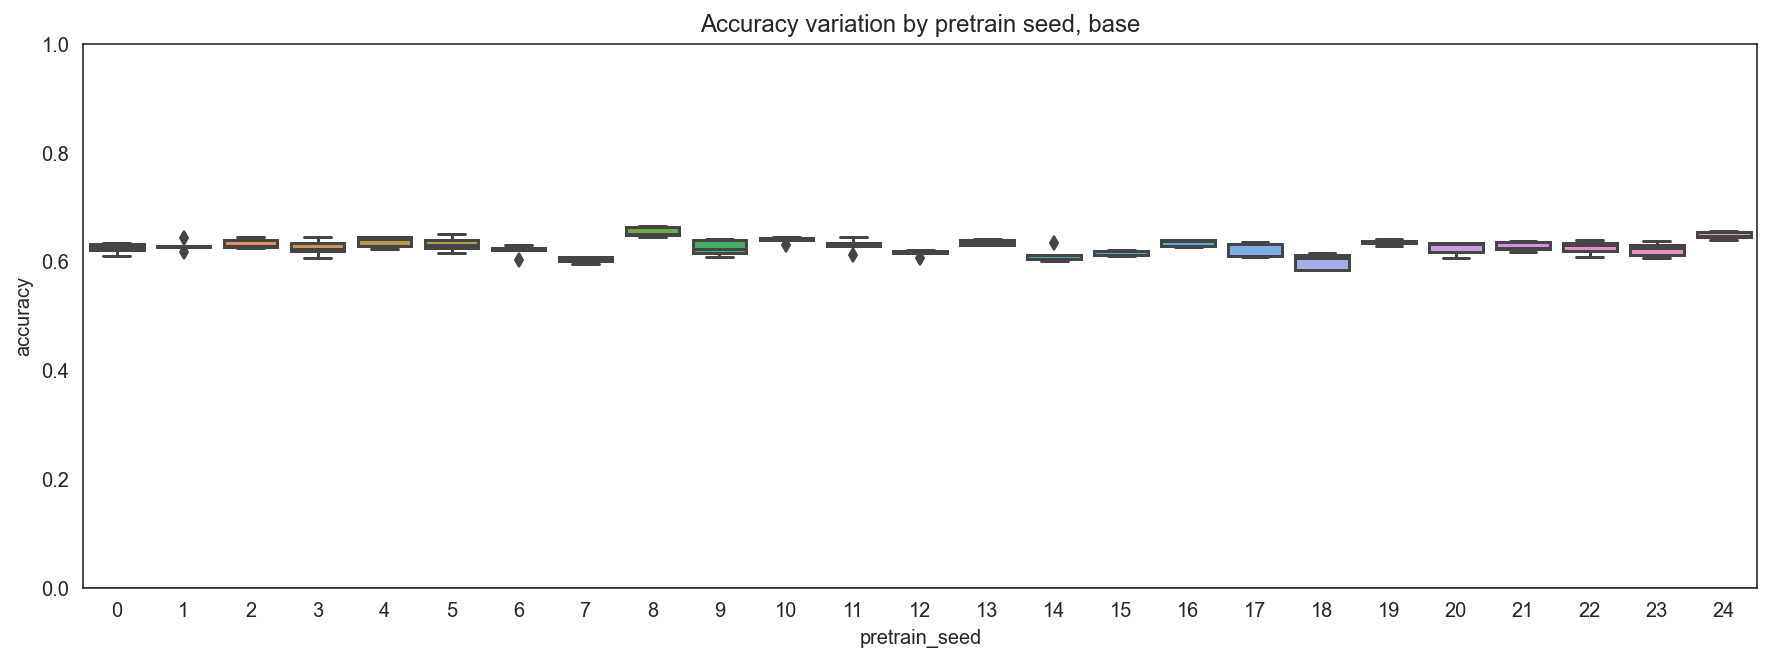

In [14]:
#@title Accuracy variation by pretrain run
fig = pyplot.figure(figsize=(15, 5))
ax = fig.gca()
sns.boxplot(ax=ax, x='pretrain_seed', y='accuracy', data=run_info[run_info.group_name == 'base'])
ax.set_title("Accuracy variation by pretrain seed, base")
ax.set_ylim(0, 1.0)
ax.axhline(0)

As a quick check, we can permute the seeds and see if much changes about our estimate:

In [15]:
# Accuracy across runs - randomized seed baseline
rng = np.random.RandomState(42)
data = run_info[run_info.group_name == 'base'].copy()
bs = data.accuracy.to_numpy()
data['accuracy_bs'] = rng.choice(bs, size=len(bs))
desc = data.groupby(by='pretrain_seed').agg(dict(accuracy_bs='mean')).describe()
print(f"With replacement:    {desc.accuracy_bs['mean']:.1%} +/- {desc.accuracy_bs['std']:.1%}")

rng = np.random.RandomState(42)
data = run_info[run_info.group_name == 'base'].copy()
bs = data.accuracy.to_numpy()
rng.shuffle(bs)
data['accuracy_bs'] = bs
desc = data.groupby(by='pretrain_seed').agg(dict(accuracy_bs='mean')).describe()
print(f"Without replacement: {desc.accuracy_bs['mean']:.1%} +/- {desc.accuracy_bs['std']:.1%}")

With replacement:    62.5% +/- 0.7%
Without replacement: 62.7% +/- 0.8%


## Figure 5 (Appendix): Bias correlation for each pre-training seed

Let's do the same as above, but for bias correlation. Again, this is on the whole run - no bootstrap yet - but should give us a sense of the variation you'd expect if you were to run this experiment ad-hoc on different pretraining seeds. As above, we'll just show the `base` runs:

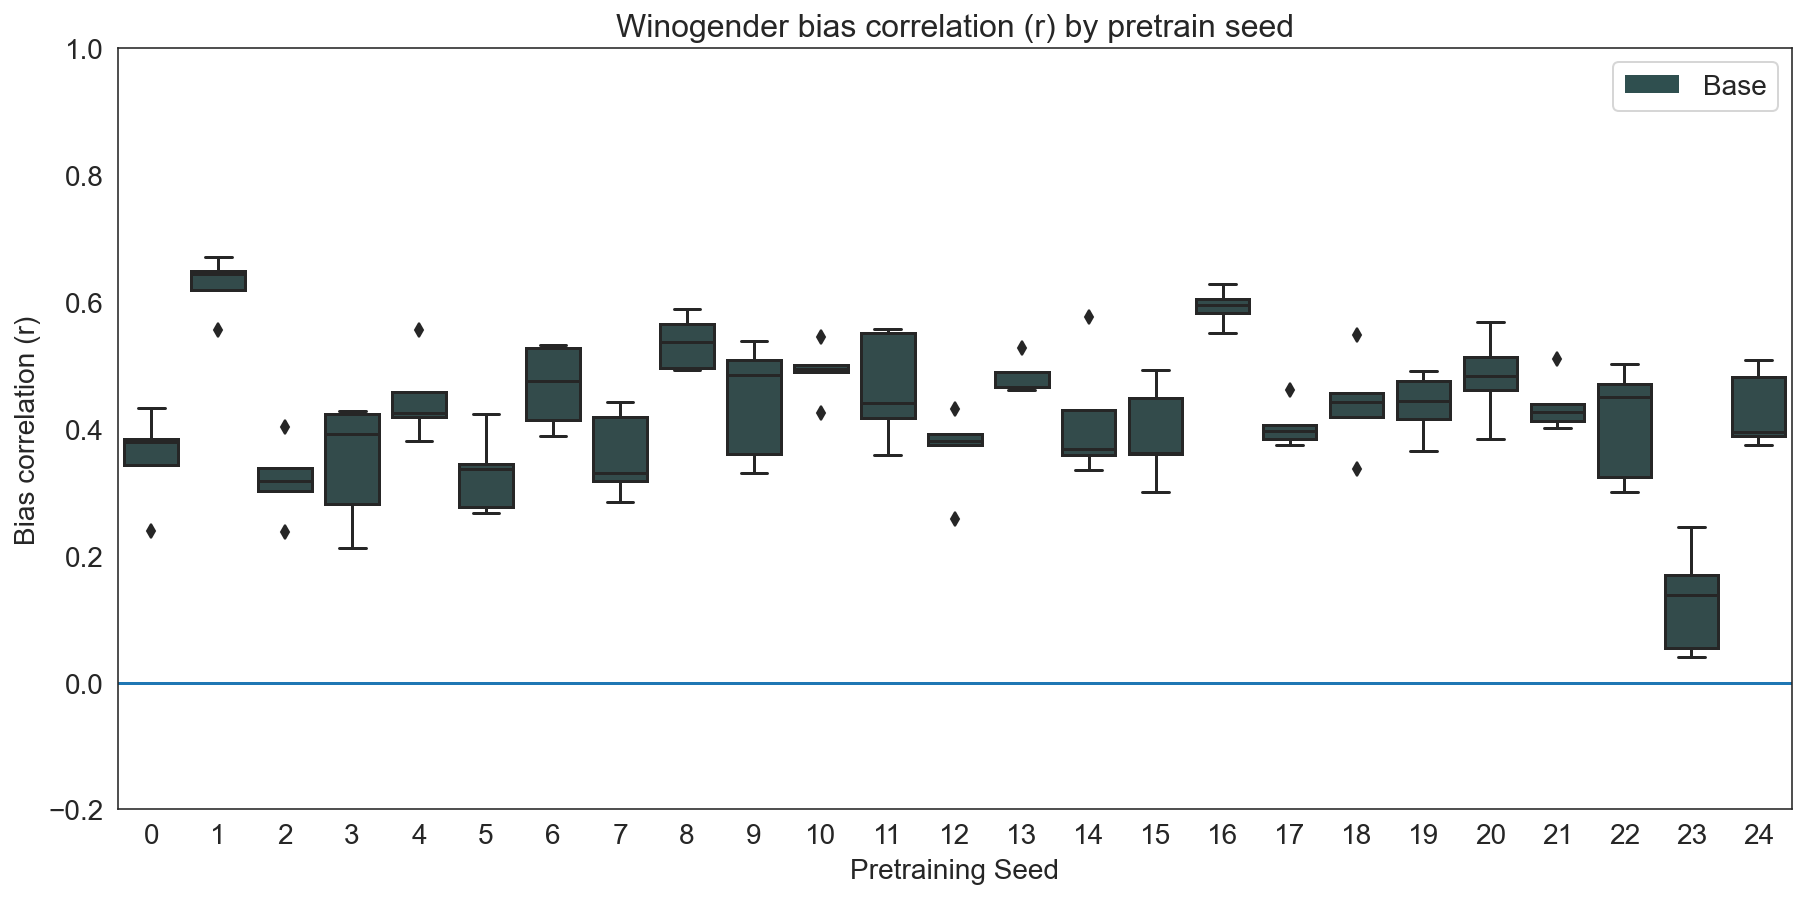

In [16]:
fig = pyplot.figure(figsize=(15, 7))
ax = fig.gca()
base = sns.boxplot(ax=ax, x='pretrain_seed', y='bias_r', data=run_info[run_info.group_name == 'base'], palette=['darkslategray'])
ax.set_title("Winogender bias correlation (r) by pretrain seed")
ax.set_ylim(-0.2, 1.0)
ax.axhline(0)

legend_elements = [matplotlib.patches.Patch(facecolor='darkslategray', label='Base')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=14)

ax.title.set_fontsize(16)
ax.set_xlabel("Pretraining Seed", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel("Bias correlation (r)", fontsize=14)
ax.tick_params(axis='y', labelsize=14)

In [17]:
# Expected range of accuracy if we randomly sampled data
import scipy.stats
[n/720.0 - 0.624 for n in scipy.stats.binom.interval(0.682, 720, 0.624)]

[-0.018444444444444485, 0.01766666666666672]

## Figure 3: Bias correlation by pretrain seed, base and CDA intervention

Now let's compare the `base` runs to running CDA for 50k steps. Again, no bootstrap yet - just plotting scores on full runs, to get a sense of how much difference we might expect to see if we did this ad-hoc and measured the effect size of CDA using just a single pretraining run.

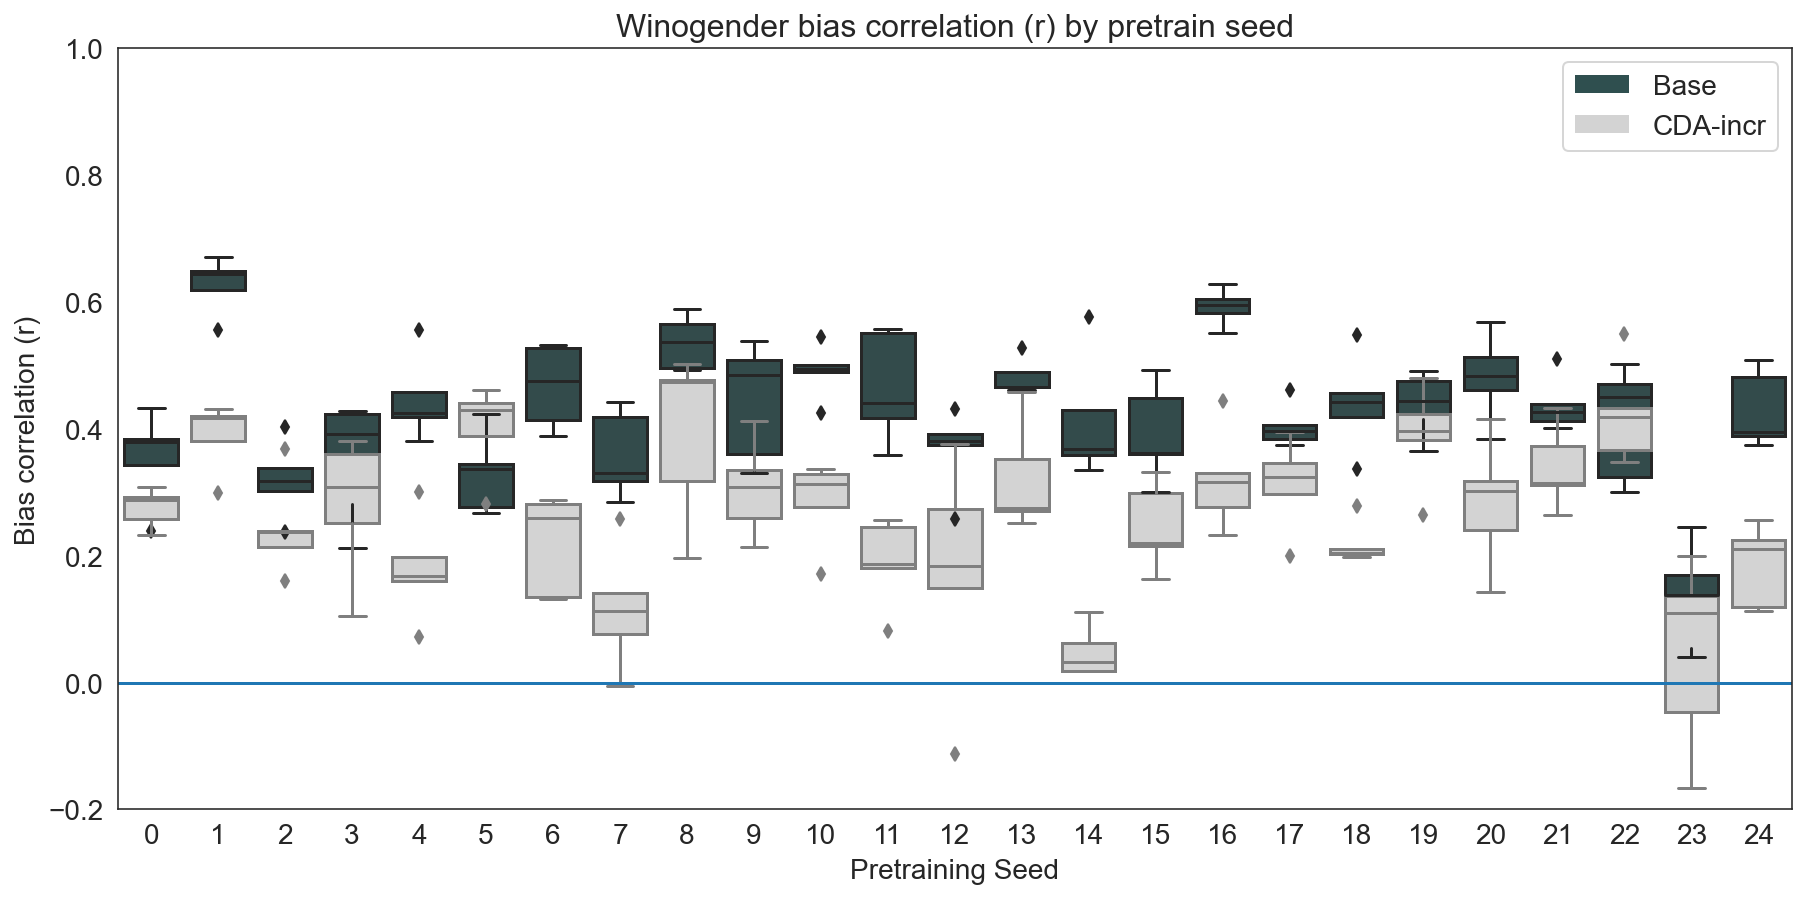

In [18]:
expt_group = "cda_intervention-50k"

fig = pyplot.figure(figsize=(15, 7))
ax = fig.gca()
base = sns.boxplot(ax=ax, x='pretrain_seed', y='bias_r', data=run_info[run_info.group_name == 'base'], palette=['darkslategray'])
expt = sns.boxplot(ax=ax, x='pretrain_seed', y='bias_r', data=run_info[run_info.group_name == expt_group], palette=['lightgray'])
ax.set_title("Winogender bias correlation (r) by pretrain seed")
ax.set_ylim(-0.2, 1.0)
ax.axhline(0)

legend_elements = [matplotlib.patches.Patch(facecolor='darkslategray', label='Base'),
                   matplotlib.patches.Patch(facecolor='lightgray', label='CDA-incr')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=14)

ax.title.set_fontsize(16)
ax.set_xlabel("Pretraining Seed", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel("Bias correlation (r)", fontsize=14)
ax.tick_params(axis='y', labelsize=14)

## Appendix D: Cross-Seed Variation

You might ask: how much of this variation is actually due to the coreference task training? We can see decently large error bars for each pretraining seed above, and we only had five coreference runs each.

One simple test is to ignore the pretraining seed. We'll create groups by randomly sampling (with replacement) five runs from the set of runs we have, then looking at the variance in the metrics. We can see that for `bias_r`, the variance is about 4x as high when using the real seeds (stdev = 0.097 vs 0.049), suggesting that most of the variation does in fact come from pretraining variation.

In [19]:
data = run_info[run_info.group_name == 'base'].copy()
bs = data.bias_r.to_numpy()
for i in range (5):
    rng = np.random.RandomState(i)
    data[f'bias_r_bs_{i}'] = rng.choice(bs, size=len(bs))
    
data.groupby(by='pretrain_seed').agg('mean').describe().loc[['mean', 'std']]

,finetune_seed,accuracy,bias_r,bias_slope,bias_r_bs_0,bias_r_bs_1,bias_r_bs_2,bias_r_bs_3,bias_r_bs_4
mean,2.0,0.627044,0.424550,0.450015,0.431620,0.432430,0.431666,0.415806,0.425594
std,0.0,0.012221,0.096832,0.108169,0.049701,0.052906,0.045431,0.045838,0.051212


### Figure 6: Extra task runs

Another way to test this is to look at the `base_extra_seeds` runs, where we ran 5 different pretraining seeds with 25 task runs. This gives us a better estimate of the mean for each pretraining seed.

Text(0, 0.5, 'Bias correlation (r)')

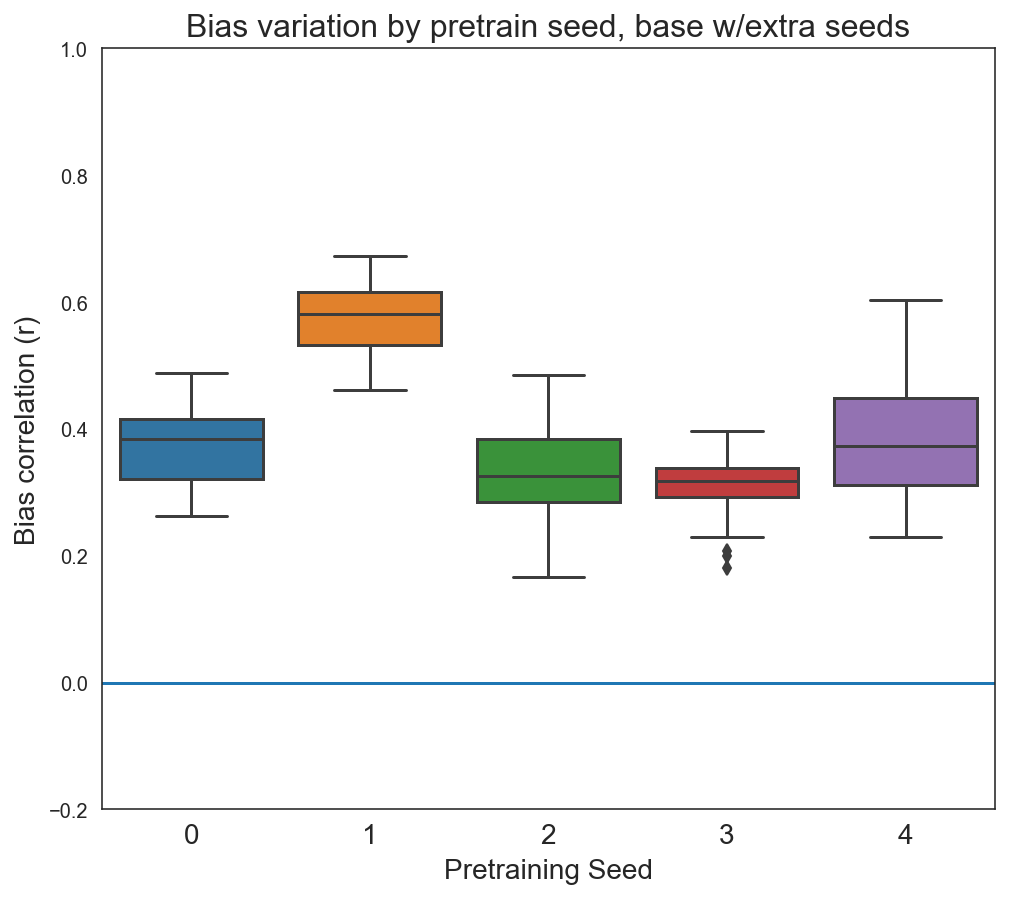

In [20]:
fig = pyplot.figure(figsize=(8, 7))
ax = fig.gca()
sns.boxplot(ax=ax, x='pretrain_seed', y='bias_r', data=run_info[run_info.group_name == 'base_extra_seeds'])
ax.set_title("Bias variation by pretrain seed, base w/extra seeds")
ax.set_ylim(-0.2, 1.0)
ax.axhline(0)

ax.title.set_fontsize(16)
ax.set_xlabel("Pretraining Seed", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel("Bias correlation (r)", fontsize=14)
#ax.tick_params(axis='y', labelsize=14)

Now we can also use the multibootstrap as a statistical test to check for differences between these seeds. We'll compare seed 0 to seed 1, and do an unpaired analysis:

In [21]:
#@title Bootstrap to test if seed 1 is different from seed 0
num_bootstrap_samples = 1000  #@param {type: "integer"}
rseed=42

mask = (run_info.group_name == 'base_extra_seeds')
mask &= (run_info.pretrain_seed == 0) | (run_info.pretrain_seed == 1)
selected_runs = run_info[mask].copy()

# Set intervention and seed columns
selected_runs['intervention'] = (selected_runs.pretrain_seed == 1)
selected_runs['seed'] = selected_runs.pretrain_seed
print("Available runs:", len(selected_runs))

##
# Compute bias r
print("Computing bias r")
labels = pf_bls.copy()
print("Labels:", labels.dtype, labels.shape)
preds = np.stack(selected_runs.bias_scores)
print("Preds:", preds.dtype, preds.shape)

metric = get_bias_corr
samples = multibootstrap.multibootstrap(selected_runs, preds, labels,
                                        metric, nboot=num_bootstrap_samples,
                                        paired_seeds=False,
                                        rng=rseed,
                                        progress_indicator=tqdm)

multibootstrap.report_ci(samples, c=0.95, expect_negative_effect=False);

Available runs: 50
Computing bias r
Labels: float64 (60,)
Preds: float64 (50, 60)
Multibootstrap (unpaired) on 60 examples
  Base seeds (1): [0]
  Base: 25 runs
  Expt seeds (1): [1]
  Expt: 25 runs


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap statistics from 1000 samples:
  E[L]  = 0.368 with 95% CI of (0.181 to 0.54)
  E[L'] = 0.571 with 95% CI of (0.409 to 0.699)
  E[L'-L] = 0.203 with 95% CI of (0.0334 to 0.378); p-value = 0.009


## Section 4.1 / Table 1: Paired analysis: base vs. CDA intervention

We've seen how much variation there can be across pretraining checkpoints, so let's use the multibootstrap to help us get a better estimate of the effectiveness of CDA. Here, we'll look at CDA for 50k steps as an intervention on the base checkpoints, and so we'll perform a paired analysis where we sample the same pretraining seeds from both sides.

base (`L`) is MultiBERTs following the original BERT recipe, and expt (`L'`) has additional steps with counterfactual data applied to these same checkpoints. We have 25 pretraining seeds on base and the same 25 pretraining seeds on expt.

In [22]:
num_bootstrap_samples = 1000  #@param {type: "integer"}
rseed=42

expt_group = "cda_intervention-50k"

mask = (run_info.group_name == 'base')
mask |= (run_info.group_name == expt_group)
selected_runs = run_info[mask].copy()

# Set intervention and seed columns
selected_runs['intervention'] = selected_runs.group_name == expt_group
selected_runs['seed'] = selected_runs.pretrain_seed
print("Available runs:", len(selected_runs))

all_samples = {}

##
# Compute accuracy
print("Computing accuracy")
labels = np.array(label_info['answer'])
print("Labels:", labels.dtype, labels.shape)
preds = np.stack(selected_runs.coref_preds)
print("Preds:", preds.dtype, preds.shape)

metric = get_accuracy
samples = multibootstrap.multibootstrap(selected_runs, preds, labels,
                                        metric, nboot=num_bootstrap_samples,
                                        paired_seeds=True,
                                        rng=rseed,
                                        progress_indicator=tqdm)
all_samples['accuracy'] = samples
multibootstrap.report_ci(all_samples['accuracy'], c=0.95, expect_negative_effect=True);

print()

##
# Compute bias r
print("Computing bias r")
labels = pf_bls.copy()
print("Labels:", labels.dtype, labels.shape)
preds = np.stack(selected_runs.bias_scores)
print("Preds:", preds.dtype, preds.shape)

metric = get_bias_corr
samples = multibootstrap.multibootstrap(selected_runs, preds, labels,
                                        metric, nboot=num_bootstrap_samples,
                                        paired_seeds=True,
                                        rng=rseed,
                                        progress_indicator=tqdm)
all_samples['bias_r'] = samples

multibootstrap.report_ci(all_samples['bias_r'], c=0.95, expect_negative_effect=True);

Available runs: 250
Computing accuracy
Labels: int64 (720,)
Preds: float64 (250, 720)
Multibootstrap (paired) on 720 examples
  Common seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Base: 125 runs
  Expt: 125 runs


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap statistics from 1000 samples:
  E[L]  = 0.626 with 95% CI of (0.599 to 0.654)
  E[L'] = 0.623 with 95% CI of (0.594 to 0.651)
  E[L'-L] = -0.00372 with 95% CI of (-0.0129 to 0.00579); p-value = 0.21

Computing bias r
Labels: float64 (60,)
Preds: float64 (250, 60)
Multibootstrap (paired) on 60 examples
  Common seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Base: 125 runs
  Expt: 125 runs


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap statistics from 1000 samples:
  E[L]  = 0.423 with 95% CI of (0.29 to 0.548)
  E[L'] = 0.261 with 95% CI of (0.115 to 0.395)
  E[L'-L] = -0.162 with 95% CI of (-0.261 to -0.0672); p-value = 0.001


### Plot result distribution

It can also be illustrative to look directly at the distribution of samples:

Bootstrap statistics from 1000 samples:
  E[L]  = 0.423 with 95% CI of (0.29 to 0.548)
  E[L'] = 0.261 with 95% CI of (0.115 to 0.395)
  E[L'-L] = -0.162 with 95% CI of (-0.261 to -0.0672); p-value = 0.001


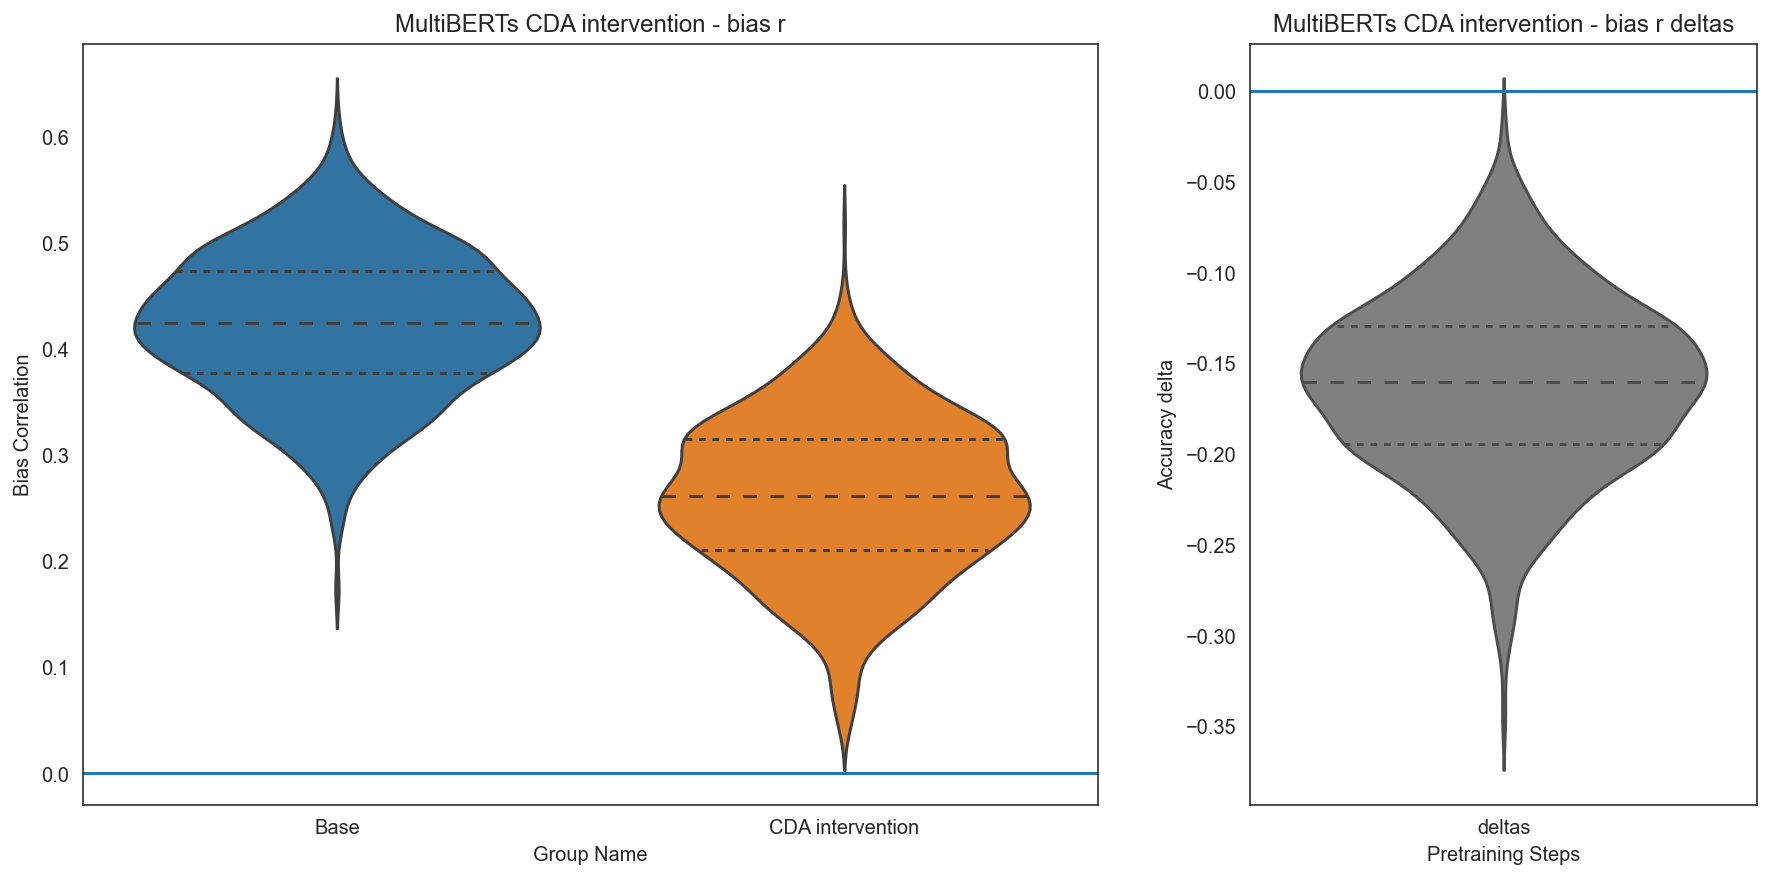

<Figure size 720x504 with 0 Axes>

In [23]:
#@title Bias r
columns = ['Base', 'CDA intervention']
var_name = 'Group Name'
val_name = "Bias Correlation"
samples = all_samples['bias_r']

fig, axs = pyplot.subplots(1, 2, gridspec_kw=dict(width_ratios=[2, 1]), figsize=(15, 7))

bdf = pd.DataFrame(samples, columns=columns).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
fig = pyplot.figure(figsize=(10, 7))
ax = axs[0]
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile')
ax.set_title("MultiBERTs CDA intervention - bias r")
ax.axhline(0)

var_name = 'Pretraining Steps'
val_name = "Accuracy delta"
bdf = pd.DataFrame(samples, columns=columns)
bdf['deltas'] = bdf['CDA intervention'] - bdf['Base']
bdf = bdf.drop(axis=1, labels=columns).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
ax = axs[1]
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile',
            palette='gray')
ax.set_title("MultiBERTs CDA intervention - bias r deltas")
ax.axhline(0)

multibootstrap.report_ci(samples, c=0.95, expect_negative_effect=True);

## Section 4.2 / Table 2: Unpaired analysis: CDA intervention vs. CDA from-scratch

Here, we'll compare our CDA 50k intervention to a set of models trained from-scratch with CDA data.

base (`L`) is the intevention CDA above, and expt (`L'`) is a similar setup but pretraining from scratch with the counterfactually-augmented data. We have 25 pretraining seeds on base and 25 pretraining seeds on expt, but these are independent runs so we'll do an unpaired analysis.

In [24]:
num_bootstrap_samples = 1000  #@param {type: "integer"}
rseed=42

base_group = "cda_intervention-50k"
expt_group = "from_scratch"

mask = (run_info.group_name == base_group)
mask |= (run_info.group_name == expt_group)
selected_runs = run_info[mask].copy()

# Set intervention and seed columns
selected_runs['intervention'] = selected_runs.group_name == expt_group
selected_runs['seed'] = selected_runs.pretrain_seed
print("Available runs:", len(selected_runs))

all_samples = {}

##
# Compute accuracy
print("Computing accuracy")
labels = np.array(label_info['answer'])
print("Labels:", labels.dtype, labels.shape)
preds = np.stack(selected_runs.coref_preds)
print("Preds:", preds.dtype, preds.shape)

metric = get_accuracy
samples = multibootstrap.multibootstrap(selected_runs, preds, labels,
                                        metric, nboot=num_bootstrap_samples,
                                        paired_seeds=False,
                                        rng=rseed,
                                        progress_indicator=tqdm)
all_samples['accuracy'] = samples
multibootstrap.report_ci(all_samples['accuracy'], c=0.95, expect_negative_effect=True);

print()

##
# Compute bias r
print("Computing bias r")
labels = pf_bls.copy()
print("Labels:", labels.dtype, labels.shape)
preds = np.stack(selected_runs.bias_scores)
print("Preds:", preds.dtype, preds.shape)

metric = get_bias_corr
samples = multibootstrap.multibootstrap(selected_runs, preds, labels,
                                        metric, nboot=num_bootstrap_samples,
                                        paired_seeds=False,
                                        rng=rseed,
                                        progress_indicator=tqdm)
all_samples['bias_r'] = samples

multibootstrap.report_ci(all_samples['bias_r'], c=0.95, expect_negative_effect=True);

Available runs: 250
Computing accuracy
Labels: int64 (720,)
Preds: float64 (250, 720)
Multibootstrap (unpaired) on 720 examples
  Base seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Base: 125 runs
  Expt seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Expt: 125 runs


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap statistics from 1000 samples:
  E[L]  = 0.623 with 95% CI of (0.592 to 0.65)
  E[L'] = 0.622 with 95% CI of (0.592 to 0.649)
  E[L'-L] = -0.00112 with 95% CI of (-0.0113 to 0.00908); p-value = 0.416

Computing bias r
Labels: float64 (60,)
Preds: float64 (250, 60)
Multibootstrap (unpaired) on 60 examples
  Base seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Base: 125 runs
  Expt seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Expt: 125 runs


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap statistics from 1000 samples:
  E[L]  = 0.256 with 95% CI of (0.115 to 0.391)
  E[L'] = 0.192 with 95% CI of (0.0678 to 0.318)
  E[L'-L] = -0.0639 with 95% CI of (-0.175 to 0.05); p-value = 0.132


Bootstrap statistics from 1000 samples:
  E[L]  = 0.256 with 95% CI of (0.115 to 0.391)
  E[L'] = 0.192 with 95% CI of (0.0678 to 0.318)
  E[L'-L] = -0.0639 with 95% CI of (-0.175 to 0.05); p-value = 0.132


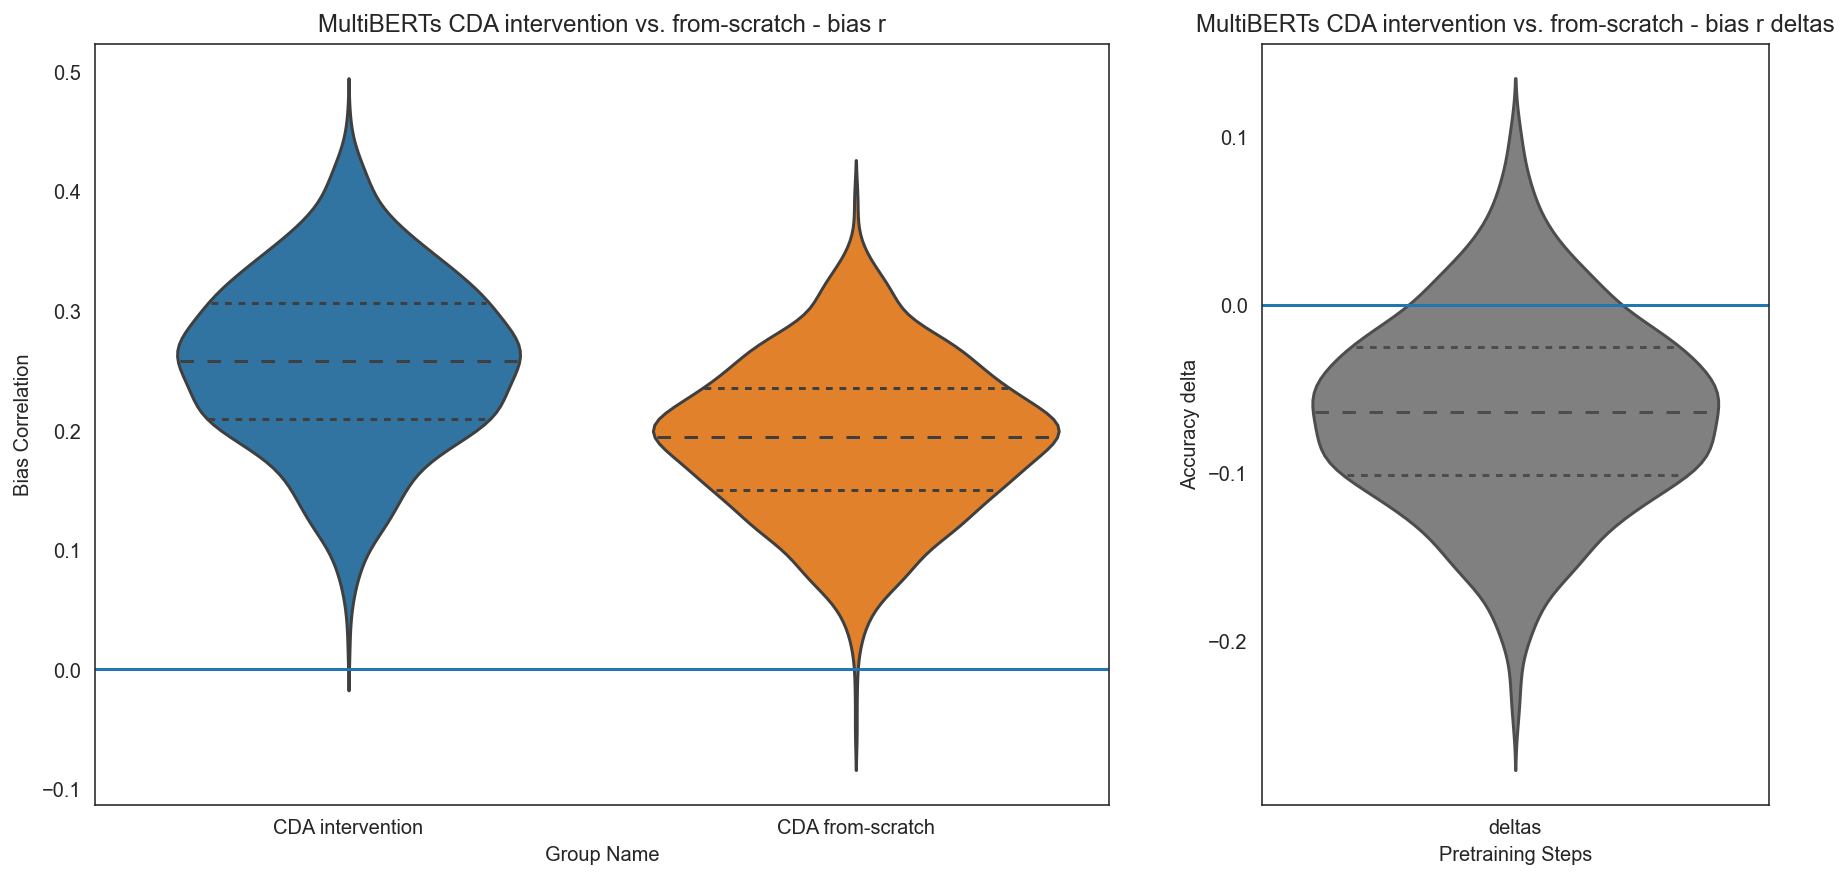

In [25]:
#@title Bias r
columns = ['CDA intervention', 'CDA from-scratch']
var_name = 'Group Name'
val_name = "Bias Correlation"
samples = all_samples['bias_r']

fig, axs = pyplot.subplots(1, 2, gridspec_kw=dict(width_ratios=[2, 1]), figsize=(15, 7))

bdf = pd.DataFrame(samples, columns=columns).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
ax = axs[0]
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile')
ax.set_title("MultiBERTs CDA intervention vs. from-scratch - bias r")
ax.axhline(0)

var_name = 'Pretraining Steps'
val_name = "Accuracy delta"
bdf = pd.DataFrame(samples, columns=columns)
bdf['deltas'] = bdf['CDA from-scratch'] - bdf['CDA intervention']
bdf = bdf.drop(axis=1, labels=columns).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
ax = axs[1]
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile',
            palette='gray')
ax.set_title("MultiBERTs CDA intervention vs. from-scratch - bias r deltas")
ax.axhline(0)

multibootstrap.report_ci(samples, c=0.95, expect_negative_effect=True);

Do we actually need to do the full multiboostrap, where we sample over both seeds and examples simultaneously? We can check this with ablations where we sample over one axis only:

1. Seeds only (`sample_examples=False`)
2. Examples only (`sample_seeds=False`)

Multibootstrap (unpaired) on 60 examples
  Base seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Base: 125 runs
  Expt seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Expt: 125 runs


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap statistics from 1000 samples:
  E[L]  = 0.264 with 95% CI of (0.223 to 0.303)
  E[L'] = 0.194 with 95% CI of (0.167 to 0.225)
  E[L'-L] = -0.0695 with 95% CI of (-0.119 to -0.0197); p-value = 0.005


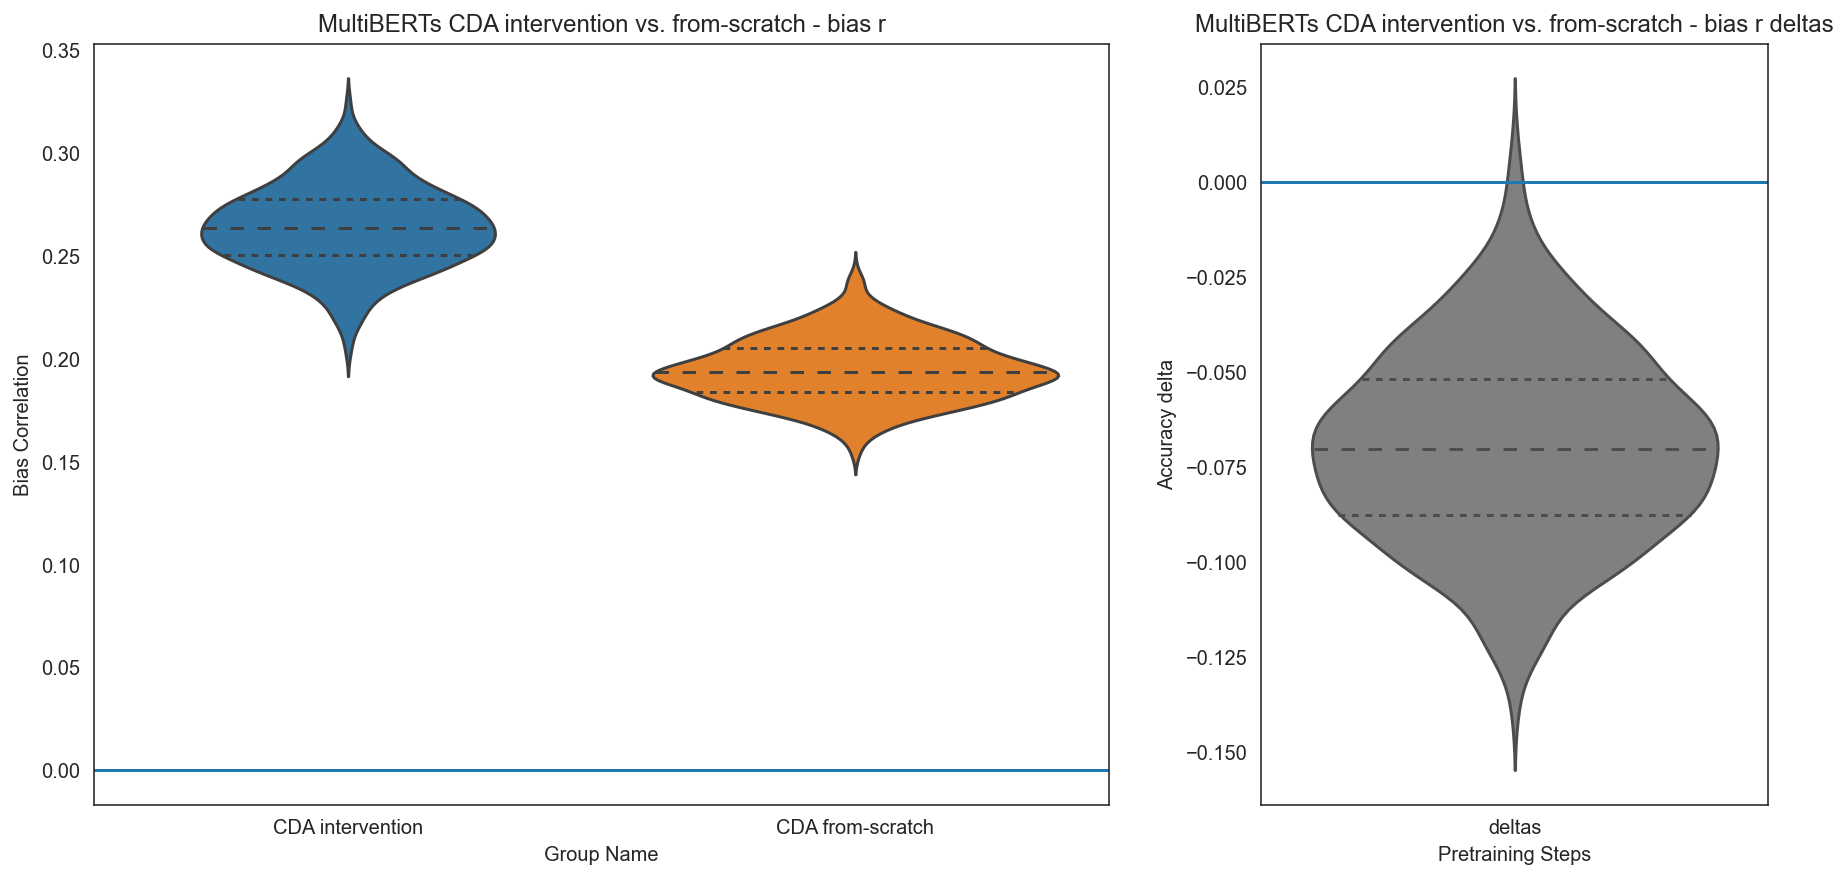

In [26]:
#@title As above, but sample seeds only
rseed=42

metric = get_bias_corr
samples = multibootstrap.multibootstrap(selected_runs, preds, labels,
                                        metric, nboot=num_bootstrap_samples,
                                        rng=rseed,
                                        paired_seeds=False,
                                        sample_examples=False,
                                        progress_indicator=tqdm)

columns = ['CDA intervention', 'CDA from-scratch']
var_name = 'Group Name'
val_name = "Bias Correlation"

fig, axs = pyplot.subplots(1, 2, gridspec_kw=dict(width_ratios=[2, 1]), figsize=(15, 7))

bdf = pd.DataFrame(samples, columns=columns).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
ax = axs[0]
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile')
ax.set_title("MultiBERTs CDA intervention vs. from-scratch - bias r")
ax.axhline(0)

var_name = 'Pretraining Steps'
val_name = "Accuracy delta"
bdf = pd.DataFrame(samples, columns=columns)
bdf['deltas'] = bdf['CDA from-scratch'] - bdf['CDA intervention']
bdf = bdf.drop(axis=1, labels=columns).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
ax = axs[1]
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile',
            palette='gray')
ax.set_title("MultiBERTs CDA intervention vs. from-scratch - bias r deltas")
ax.axhline(0)

multibootstrap.report_ci(samples, c=0.95, expect_negative_effect=True);

Multibootstrap (unpaired) on 60 examples
  Base seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Base: 125 runs
  Expt seeds (25): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Expt: 125 runs


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap statistics from 1000 samples:
  E[L]  = 0.259 with 95% CI of (0.118 to 0.39)
  E[L'] = 0.193 with 95% CI of (0.0732 to 0.309)
  E[L'-L] = -0.0668 with 95% CI of (-0.149 to 0.0121); p-value = 0.053


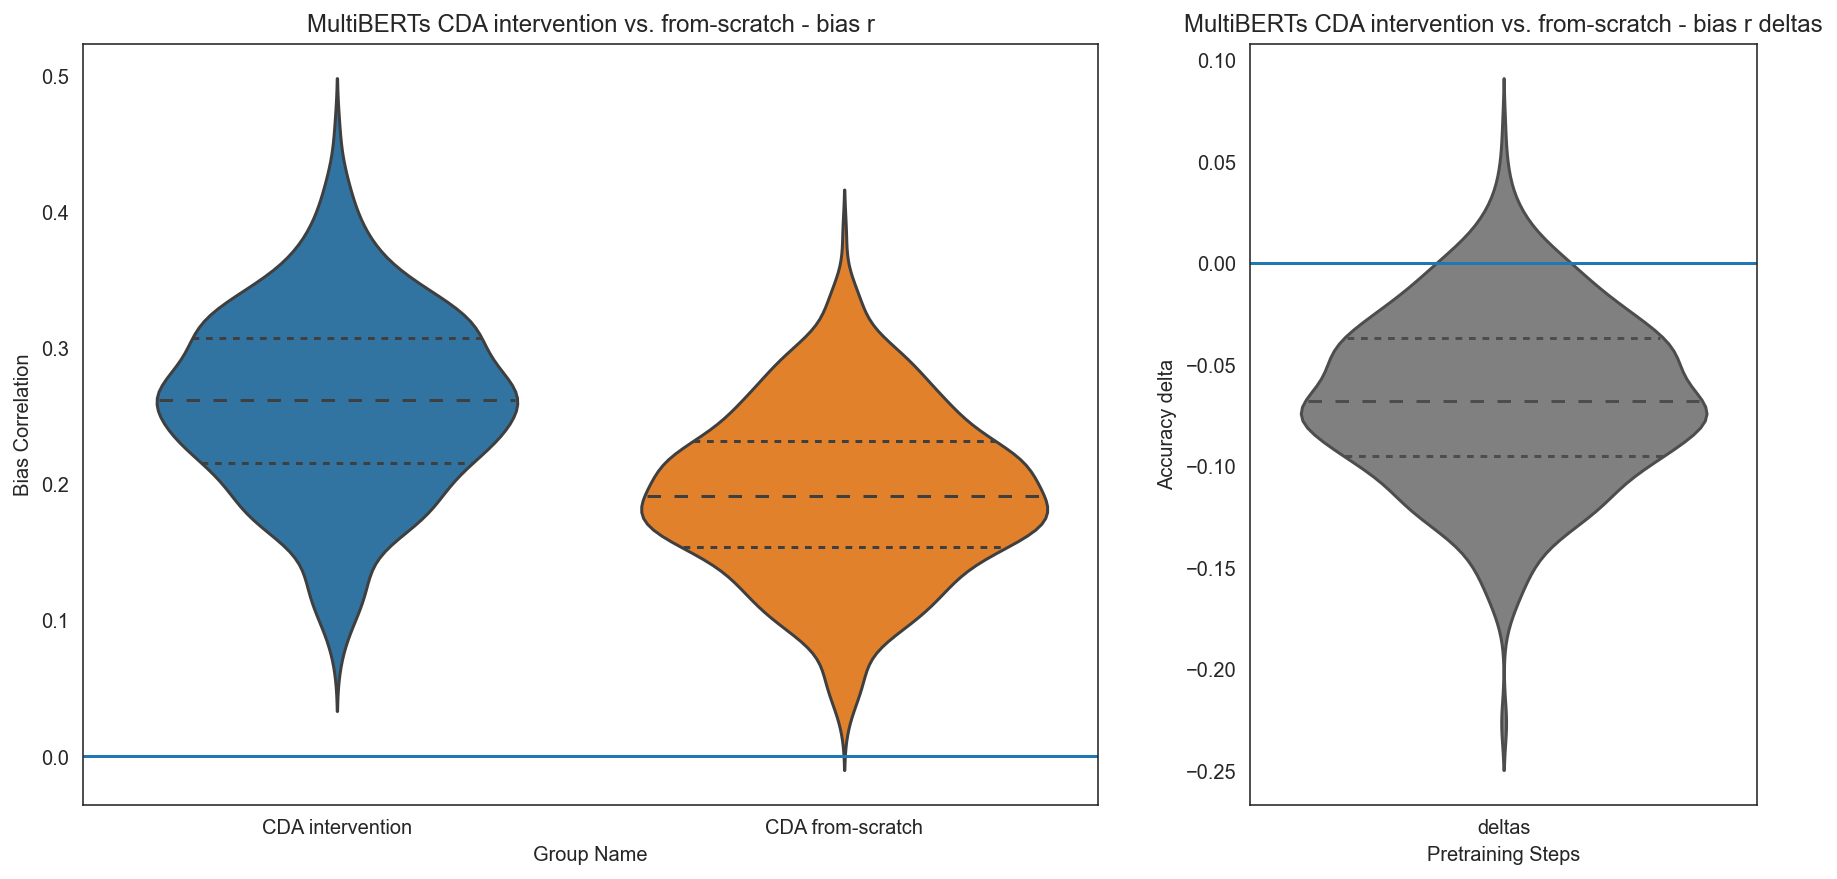

In [27]:
#@title As above, but sample examples only
rseed=42

metric = get_bias_corr
samples = multibootstrap.multibootstrap(selected_runs, preds, labels,
                                        metric, nboot=num_bootstrap_samples,
                                        rng=rseed,
                                        paired_seeds=False,
                                        sample_seeds=False,
                                        progress_indicator=tqdm)

columns = ['CDA intervention', 'CDA from-scratch']
var_name = 'Group Name'
val_name = "Bias Correlation"

fig, axs = pyplot.subplots(1, 2, gridspec_kw=dict(width_ratios=[2, 1]), figsize=(15, 7))

bdf = pd.DataFrame(samples, columns=columns).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
ax = axs[0]
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile')
ax.set_title("MultiBERTs CDA intervention vs. from-scratch - bias r")
ax.axhline(0)

var_name = 'Pretraining Steps'
val_name = "Accuracy delta"
bdf = pd.DataFrame(samples, columns=columns)
bdf['deltas'] = bdf['CDA from-scratch'] - bdf['CDA intervention']
bdf = bdf.drop(axis=1, labels=columns).melt(var_name=var_name, value_name=val_name)
bdf['x'] = 0
ax = axs[1]
sns.violinplot(ax=ax, x=var_name, y=val_name, data=bdf, inner='quartile',
            palette='gray')
ax.set_title("MultiBERTs CDA intervention vs. from-scratch - bias r deltas")
ax.axhline(0)

multibootstrap.report_ci(samples, c=0.95, expect_negative_effect=True);

In both of the above, we get lower p-values - suggesting that if we don't account jointly for _both_ sources of variation, we could end up making overly-confident conclusions about the difference between these methods.